In [37]:
import pandas as pd
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split # Newer versions
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import datasets, svm
import matplotlib.pyplot as plt
import random
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import time
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import pickle
import scipy.sparse
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV


# mute warning that assign columns on dataframe   eg,  df["col1"] = df["col11"]
pd.options.mode.chained_assignment = None  # default='warn'



# Store Original data
whole_data = pd.read_csv(r"data/recipe_train.csv", index_col = False, delimiter = ',', header=0)

## Read Files 

In [20]:
# Store Original data
whole_data = pd.read_csv(r"data/recipe_train.csv", index_col = False, delimiter = ',', header=0)



# Split into attributes and class
y_df = whole_data["duration_label"]    #class df
x_df = whole_data.drop(['duration_label'], axis=1)    # features df

# train test split
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size = 0.33, random_state = 123)
print('X_train: {} X_test: {}'.format(X_train.shape, X_test.shape))

X_train: (26800, 5) X_test: (13200, 5)


In [ ]:
# Small test Data
# random sample part of data for plotting use
sample_data = whole_data.sample(1000)
# Split into attributes and class
sample_y_df = sample_data["duration_label"]    #class df
sample_x_df = sample_data.drop(['duration_label'], axis=1)    # features df

# train test split
sample_X_train, sample_X_test, sample_y_train, sample_y_test = train_test_split(sample_x_df, sample_y_df, test_size = 0.33, random_state = 123)
print('X_train: {} X_test: {}'.format(sample_X_train.shape, sample_X_test.shape))

### Explore the relations between n_steps, n_ingredients  with Cooking Time

In [ ]:
## Only Using n_steps and n_ingredients

# use random sample instead of full size to generate better graph
sample_X_train = sample_X_train.loc[:,["n_ingredients", "n_steps"]]

# Plot the training points
plt.scatter(sample_X_train["n_ingredients"], sample_X_train["n_steps"], c = sample_y_train, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('n_ingredients')
plt.ylabel('n_steps')
plt.xticks(())
plt.yticks(())
plt.title("n_ingredients & n_steps VS Cooking Time")
plt.show()

plt.scatter(sample_X_train["n_steps"], sample_y_train, c = sample_y_train, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('n_steps')
plt.ylabel('Cooking Time')
plt.xticks(())
plt.yticks(())
plt.title("n_steps vs cooking time")
plt.show()

plt.scatter(sample_X_train["n_ingredients"], sample_y_train, c = sample_y_train, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('n_ingredients')
plt.ylabel('Cooking Time')
plt.xticks(())
plt.yticks(())
plt.title("n_ingredients vs cooking time")
plt.show()



As graph shown above, simply using n_ingredients and n_steps cannot do the classification,
for the reason that the numbers of steps / ingredients cannot form clear clusters to classify cooking time

## Only use n_steps and n_ingredients to do prediction

In [ ]:
X_train = X_train[["n_steps", "n_ingredients"]]
X_train.head(3)
X_test = X_test[["n_steps", "n_ingredients"]]
X_test.head(3)

In [ ]:
# From workshop 06, using SVM with linear SVM and cubic SVM to do the classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#print(cross_val_score(zero_r, X, y, cv=10))
X = X_train
y = y_train

#try to change C to 1000 or 0.001
C = 1.0  # SVM regularization parameter

models = [DecisionTreeClassifier(max_depth=1),
          KNeighborsClassifier(n_neighbors=1),
          KNeighborsClassifier(n_neighbors=5),
          DecisionTreeClassifier(max_depth=50),
          svm.LinearSVC(C=C, max_iter = 200),]
          #svm.SVC(kernel='rbf', gamma=0.7, C=C)]

titles = ['1-R',
          '1-Nearest Neighbour',
          '5-Nearest Neighbour',
          'Decision Tree',
          'LinearSVC',]
          #'SVM with a cubic kernel']

title_training_acc = {}
for title, model in zip(titles, models):
    model.fit(X, y)
    title_training_acc[title] = model.score(X,y)

title_crossvalidation_acc = {}
for title, model in zip(titles, models):
    title_crossvalidation_acc[title] = cross_val_score(model, X, y, cv = 10).mean()

for title in titles:
    print(title, ': Training Acc', title_training_acc[title], '; X-Val Acc', title_crossvalidation_acc[title])
    

Overall, we found that the SVM method using only n_steps and n_ingredients doesn't perform well, as the result is close to 0-R baseline

## Using Stacking Classifier

code from workshop 08

- 'Zero-R',
- 'Logistic Regression',
- 'Decision Tree',
- 'KNN',
- 'GaussianNB',
- 'Logistic Regression'

In [ ]:


np.random.seed(1)

class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0]
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)


classifiers = [DummyClassifier(strategy='most_frequent'),
               
          LogisticRegression(random_state=10),
          DecisionTreeClassifier(random_state=10),
          KNeighborsClassifier(),
          GaussianNB(),
        LogisticRegression(random_state=10)]
titles = ['Zero-R',
          'Logistic Regression',
          'Decision Tree',
          'KNN',
          'GaussianNB',
          'Logistic Regression']

meta_classifier = LogisticRegression()
stacker = StackingClassifier(classifiers, meta_classifier)
    

In [ ]:
# Do prediction using stacking
for title, model in zip(titles, models):
    model.fit(X_train,y_train)
    start = time.time()
    acc = model.score(X_test, y_test)
    end = time.time()
    t = end-start
    print(title, "Accuracy:",acc, 'Time:', t)
stacker.fit(X_train, y_train)
print("\n\nTotal Performance:")
print('\nStacker Accuracy:', stacker.score(X_test, y_test))

Overall, using specific n_steps and n_ingredients may not be good enough

# Neural Net Work Part
# ----------------------------------------------
### Load Vectorized Data and Use Neural Network

## Select k Best features for classification

### Combining 
1. Standarlise
2. TOP K feature selection
3. fit to Neural Network

## 1.1 doc2vec Combining step, ingredients using df Concatenate

In [ ]:
import pandas as pd
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split # Newer versions
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import datasets, svm
import matplotlib.pyplot as plt
import random
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import time
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


# mute warning that assign columns on dataframe   eg,  df["col1"] = df["col11"]
pd.options.mode.chained_assignment = None  # default='warn'

In [42]:
# Read Data
# Store Original data
whole_data = pd.read_csv(r"data/recipe_train.csv", index_col = False, delimiter = ',', header=0)

# for each one
step = pd.read_csv(r"data/train_steps_doc2vec50.csv",header=None ,index_col = False, delimiter = ',')
step_df = pd.DataFrame(step)
ingr = pd.read_csv(r"data/train_ingr_doc2vec50.csv",header=None ,index_col = False, delimiter = ',')
ingr_df = pd.DataFrame(ingr)
name = pd.read_csv(r"data/train_name_doc2vec50.csv",header=None ,index_col = False, delimiter = ',')
name_df = pd.DataFrame(name)

# Combining Dataframes
combined_df = pd.concat([step_df,ingr_df,name_df], axis=1)
#combined_df


In [25]:
#Doing classification
X_train = combined_df
y_train = whole_data["duration_label"]

# 1. Standarlise
scaler = StandardScaler()

# 2. Feature Selection (selecting best vectorlised words we can use)
mi = SelectKBest(mutual_info_classif,k=30)  # top k good features

# 3. NN Model
clf = MLPClassifier(max_iter=2000)

# Combining 1,2,3 into pipline
pipeline = Pipeline([('transformer', scaler),('select k best feature', mi), ('estimator', clf)])


# Get Result
print('corss-val noncheating standardised features acc:', np.mean(cross_val_score(pipeline, X_train, y_train, cv=5)))

corss-val noncheating standardised features acc: 0.6605


As mentioned above, combining steps, ingridients, name matrix and find best 30 features using mutual information

## 1.2 doc2vec Combining step, ingredients, n_steps, n_ingredients using df Concatenate

In [86]:
# Store Original data
whole_data = pd.read_csv(r"data/recipe_train.csv", index_col = False, delimiter = ',', header=0)

# Read Data
#vocab = pickle.load(open("train_name_countvectorizer.pkl", "rb"))
step = pd.read_csv(r"data/train_steps_doc2vec50.csv",header=None ,index_col = False, delimiter = ',')
step_df = pd.DataFrame(step)
ingr = pd.read_csv(r"data/train_ingr_doc2vec50.csv",header=None ,index_col = False, delimiter = ',')
ingr_df = pd.DataFrame(ingr)
name = pd.read_csv(r"data/train_name_doc2vec50.csv",header=None ,index_col = False, delimiter = ',')
name_df = pd.DataFrame(name)
nstep = whole_data["n_steps"]
ningr = whole_data["n_ingredients"]

# Combining Dataframes
combined_df = pd.concat([nstep,ningr,step_df,ingr_df,name_df], axis=1)

In [93]:
#Doing classification
X_train = combined_df.iloc[0:1000,]

y_train = whole_data["duration_label"].iloc[0:1000,]

## 1. Standarlise
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# 2. Feature Selection (selecting best vectorlised words we can use)
mi = SelectKBest(mutual_info_classif,k=150)  # top k good features
X_train = mi.fit_transform(X_train,y_train)

#X_test_x2 = x2.transform(X_test)
# 3. NN Model
clf = MLPClassifier(max_iter=2000,random_state=2)




# Get Result
print('corss-val noncheating standardised features acc:', np.mean(cross_val_score(clf, X_train, y_train, cv=5)))

corss-val noncheating standardised features acc: 0.6260000000000001


### 1.3 Find if StandardScaler() will make a difference to our model 

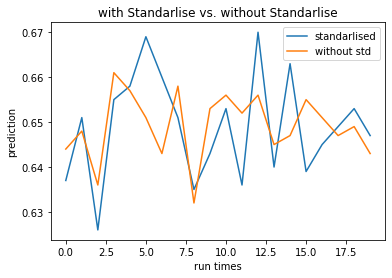

Accuracy with Standarlised model: 0.649
Accuracy without Standarlised model: 0.6492000000000001


In [95]:
## Find if using StandardScaler() will make a difference to our model 

# Store different scores for using StandardScaler() and not
score_std=[]
score_without_std=[]

# iterate through different random state using StandardScaler()
for i in range(0,20):
    X_train = combined_df.iloc[0:1000,]
    y_train = whole_data["duration_label"].iloc[0:1000,]

    ## 1. Standarlise
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    # 2. Feature Selection (selecting best vectorlised words we can use)
    mi = SelectKBest(mutual_info_classif,k=150)  # top k good features
    X_train = mi.fit_transform(X_train,y_train)
    # 3. NN Model
    clf = MLPClassifier(max_iter=2000,random_state=i)
    # Get Result
    score_std.append(np.mean(cross_val_score(clf, X_train, y_train, cv=5)))
    
# iterate through different random state without using StandardScaler()
for i in range(0,20):
    X_train = combined_df.iloc[0:1000,]
    y_train = whole_data["duration_label"].iloc[0:1000,]

    ## 1. Standarlise
    scaler = StandardScaler()
    # 2. Feature Selection (selecting best vectorlised words we can use)
    mi = SelectKBest(mutual_info_classif,k=150)  # top k good features
    X_train = mi.fit_transform(X_train,y_train)
    # 3. NN Model
    clf = MLPClassifier(max_iter=2000,random_state=i)
    # Get Result
    score_without_std.append(np.mean(cross_val_score(clf, X_train, y_train, cv=5)))
    
    
plt.plot(range(len(score_std)), score_std, label='standarlised')
plt.plot(range(len(score_without_std)), score_without_std, label='without std')
plt.title('with Standarlise vs. without Standarlise')
plt.ylabel('prediction')
plt.xlabel('run times')
plt.legend()
plt.show()
print("Accuracy with Standarlised model:", np.mean(score_std))
print("Accuracy without Standarlised model:", np.mean(score_without_std))

As plot shown above, using standarlised scaler doesn't affect much accuracy for our model



## 2.1 countVec Combining step, ingredients using sparce matrix Concatenate


#### 2.1.1 Select Dtop 500 features from ingredients, steps separately, THEN combing them into dataframe.

In [40]:
# Store Original data
whole_data = pd.read_csv(r"data/recipe_train.csv", index_col = False, delimiter = ',', header=0)
y_train = whole_data["duration_label"]
# Feature Selection to reduce size
mi = SelectKBest(mutual_info_classif,k=500)  # top k good features


# Read Data and convert to dataframe
step = scipy.sparse.load_npz("data/train_steps_vec.npz")
step = mi.fit_transform(step,y_train)   # Feature Selection to reduce size

# ingr data
ingr = scipy.sparse.load_npz("data/train_ingr_vec.npz")
ingr = mi.fit_transform(ingr,y_train)   # Feature Selection to reduce size

# name data
name = scipy.sparse.load_npz("data/train_name_vec.npz")
name = mi.fit_transform(name,y_train)   # Feature Selection to reduce size

nstep = whole_data["n_steps"]
ningr = whole_data["n_ingredients"]

# Combining Dataframes
combined_matrix = hstack((step, ingr, name))
combined_vec_df = pd.DataFrame.sparse.from_spmatrix(combined_matrix, index=None, columns=None)

combined_df = pd.concat([nstep,ningr,combined_vec_df], axis=1)
#combined_df

#### 2.1.2 Using Combined Dataframe (n_steps, n_ingrs, steps, ingrs), use grid search to find optimum parameters
1. choose optimal top k features
2. reduce the size of the model by using top k features
3. use grid search to find best parameters for NN algorithm

#### 2.1.3 Using Grid Search to Find Optimal Parameters
Code from Practical-11-2021

In [41]:
#Doing classification
X_train = combined_df
y_train = whole_data["duration_label"]

## 1. Standarlise
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)


# 2. #####  Feature Selection (selecting best vectorlised words we can use)
mi = SelectKBest(mutual_info_classif,k=50)  # top k good features

# Doing Grid Search For finding best k good features
k = [10,20,50,100]
param_grid = {'k': k}
gs = GridSearchCV(estimator=mi,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1,
                  verbose=1)
gs.fit(X_train, y_train)
best_k = gs.best_params_
print('best k value for feature selection', best_k)
mi = SelectKBest(mutual_info_classif, **best_k)
# put model to change training data
X_train = mi.fit_transform(X_train,y_train)



# 3. #####  NN Classification (selecting best vectorlised words we can use)

clf = MLPClassifier(max_iter=2000,random_state=2)

# without grid search tuning
clf.fit(X_train, y_train)
print('MLP acc without tuning:', clf.score(X_train, y_train))

#arguments of MLPClassifier and a list of values for them to search and find the best.
alphas = [np.power(10.0, i) for i in range(-7, 2)]
hidden_sizes = [[100], [10, 10], [80,50,20]]
param_grid = {'alpha': alphas, 'hidden_layer_sizes':hidden_sizes}

# Do Grid Search
gs = GridSearchCV(estimator=clf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1,
                  verbose=1)
gs.fit(X_train, y_train)

# Print Result
best_params = gs.best_params_
print('best_params', best_params)

# Do Neural Network with best parameters
clf = MLPClassifier(max_iter=2000, **best_params, random_state=2)
clf.fit(X_train, y_train)
print('acc with best params:', clf.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

# 
# Bibliograhy:
# 

Generating Personalized Recipes from Historical User Preferences. Bodhisattwa Prasad Majumder,
Shuyang Li, Jianmo Ni, Julian McAule+y, in Proceedings of the 2019 Conference on Empirical
Methods in Natural Language Processing and the 9th International Joint Conference on Natural
Language Processing (EMNLP-IJCNLP), 2019.